In [3]:
import torch
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import pygad.torchga

import torchvision
from torchvision.datasets import CIFAR100, CIFAR10
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

gpu_is_available = torch.cuda.is_available()
if gpu_is_available:
    print('Training with GPU')

Training with GPU


In [4]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


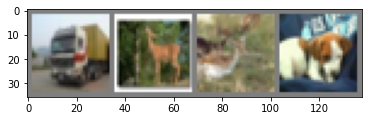

truck  deer  deer   dog


In [5]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [7]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()
if gpu_is_available:
    net = net.cuda()
net

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [10]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, (inp, lbl) in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        if gpu_is_available:
            inputs, labels = inp.cuda(), lbl.cuda()
        else:    
            inputs, labels = inp, lbl

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.201
[1,  4000] loss: 1.892
[1,  6000] loss: 1.697
[1,  8000] loss: 1.583
[1, 10000] loss: 1.514
[1, 12000] loss: 1.429
[2,  2000] loss: 1.374
[2,  4000] loss: 1.365
[2,  6000] loss: 1.341
[2,  8000] loss: 1.286
[2, 10000] loss: 1.270
[2, 12000] loss: 1.267
Finished Training


In [32]:
model = Net()
# if gpu_is_available:
#     model = model.cuda()
torch_ga = pygad.torchga.TorchGA(model=model, num_solutions=10)

In [61]:
loss_function = nn.CrossEntropyLoss()

def fitness_func(solution, sol_idx):
    global trainloader, torch_ga, model, loss_function

    model_weights_dict = pygad.torchga.model_weights_as_dict(model=model,
                                                         weights_vector=solution)

    # Use the current solution as the model parameters.
    model.load_state_dict(model_weights_dict)
    
    losses = []
    for img, lbl in trainloader:
        predictions = model(img)
        losses.append(loss_function(predictions, lbl).item())
    
    loss = np.array(losses)
    solution_fitness = 1.0 / (loss.mean() + 0.00000001)

    return solution_fitness

In [62]:
def callback_generation(ga_instance):
    print("Generation = {generation}".format(generation=ga_instance.generations_completed))
    print("Fitness    = {fitness}".format(fitness=ga_instance.best_solution()[1]))

In [63]:
num_generations = 250
num_parents_mating = 5
initial_population = torch_ga.population_weights

ga_instance = pygad.GA(num_generations=num_generations, 
                       num_parents_mating=num_parents_mating, 
                       initial_population=initial_population,
                       fitness_func=fitness_func,
                       on_generation=callback_generation)

In [ ]:
ga_instance.run()

Generation = 1


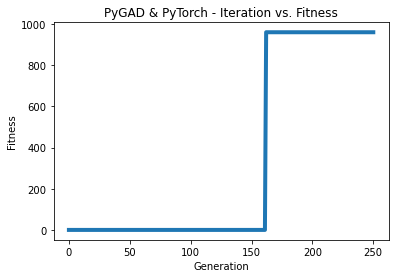

In [102]:
ga_instance.plot_result(title="PyGAD & PyTorch - Iteration vs. Fitness", linewidth=4)
plt.show()

In [106]:
# Returning the details of the best solution.
solution, solution_fitness, solution_idx = ga_instance.best_solution()
print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=solution_fitness))
print("Index of the best solution : {solution_idx}".format(solution_idx=solution_idx))

# Fetch the parameters of the best solution.
best_solution_weights = pygad.torchga.model_weights_as_dict(model=model,
                                                      weights_vector=solution)
model.load_state_dict(best_solution_weights)
predictions = model(inputs)
# print("Predictions : \n", predictions)

# Calculate the crossentropy for the trained model.
print("Crossentropy : ", loss_function(predictions, labels).detach().numpy())

# Calculate the classification accuracy for the trained model.
accuracy = torch.sum(torch.max(predictions, axis=1).indices == labels) // len(labels)
print("Accuracy : ", accuracy.detach().numpy())

Fitness value of the best solution = 960.5668851145416
Index of the best solution : 0
Crossentropy :  0.0010410419
Accuracy :  1


In [4]:
import os
from glob import glob

import pandas as pd
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [5]:
root_dir = './data/'
img_path = root_dir + 'Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/'
train_dir = img_path + 'train'
test_dir = img_path + 'test'

In [6]:
metadata = pd.read_csv(os.path.join(root_dir, 'Chest_xray_Corona_Metadata.csv'))

In [7]:
df_train = metadata[metadata['Dataset_type']=='TRAIN']
df_test = metadata[metadata['Dataset_type']=='TEST']

print('Training data:', df_train.shape)
print('Testing data:', df_test.shape)

Training data: (5286, 6)
Testing data: (624, 6)


In [8]:
df_train.loc[df_train['Label'].eq('Normal'), 'class'] = 'healthy'
df_train.loc[(df_train['class'].ne('healthy') & df_train['Label_1_Virus_category'].eq('bacteria')), 'class'] = 'COVID-19';
df_train.loc[(df_train['class'].ne('healthy') & df_train['class'].ne('bacteria') & df_train['Label_2_Virus_category'].eq('COVID-19')), 'class'] = 'COVID-19';
df_train.loc[(df_train['class'].ne('healthy') & df_train['class'].ne('bacteria') & df_train['class'].ne('COVID-19')), 'class'] = 'COVID-19';

df_test.loc[df_test['Label'].eq('Normal'), 'class'] = 'healthy'
df_test.loc[(df_test['class'].ne('healthy') & df_test['Label_1_Virus_category'].eq('bacteria')), 'class'] = 'COVID-19';
df_test.loc[(df_test['class'].ne('healthy') & df_test['class'].ne('bacteria') & df_test['Label_2_Virus_category'].eq('COVID-19')), 'class'] = 'COVID-19';
df_test.loc[(df_test['class'].ne('healthy') & df_test['class'].ne('bacteria') & df_test['class'].ne('COVID-19')), 'class'] = 'COVID-19';

print(df_train['class'].value_counts())
print(df_test['class'].value_counts())

COVID-19    3944
healthy     1342
Name: class, dtype: int64
COVID-19    390
healthy     234
Name: class, dtype: int64


C:\Users\Archel\anaconda3\envs\machine-learning\lib\site-packages\pandas\core\indexing.py:1599: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = infer_fill_value(value)
C:\Users\Archel\anaconda3\envs\machine-learning\lib\site-packages\pandas\core\indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [9]:
target_dict = {'healthy': 0, 'COVID-19': 1}
df_train['target'] = df_train['class'].map(target_dict)
df_test['target'] = df_test['class'].map(target_dict)

<ipython-input-9-393ffe4e6108>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['target'] = df_train['class'].map(target_dict)
<ipython-input-9-393ffe4e6108>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['target'] = df_test['class'].map(target_dict)


In [10]:
class CoronaHackDataset(Dataset):
    
    def __init__(self, metadata, root_dir, transform=None):
        self.root_dir = root_dir
        self.metadata = metadata
        self.transform = transform
        self.list_dir = os.listdir(root_dir)
        
    def __len__(self):
        return len(self.metadata)
    
    def __getitem__(self, idx):
        metadata = self.metadata.iloc[idx]
        fname = metadata['X_ray_image_name']
        
        try:
            file_idx = self.list_dir.index(fname)
        except:
            print('Image not found!')
            return None
        
        img_path = os.path.join(self.root_dir, self.list_dir[file_idx])
        img = Image.open(img_path).convert('RGB')
        img = img.resize((128,128))
        tensor_img = self.transform(img)
        tensor_lbl = torch.tensor(metadata['target'].item())
        
        return tensor_img, tensor_lbl

In [11]:
batch_size = 32
normalize = False
stats = ((0.0093, 0.0093, 0.0092),(0.4827, 0.4828, 0.4828))

if normalize:
    train_tfms = torchvision.transforms.ToTensor()
else:
    train_tfms = torchvision.transforms.Compose([torchvision.transforms.CenterCrop(128), torchvision.transforms.ToTensor(), torchvision.transforms.Normalize(*stats, inplace=True)])
    
test_tfms = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), torchvision.transforms.Normalize(*stats, inplace=True)])

In [12]:
train_ds, val_ds = train_test_split(df_train, test_size=0.12, random_state=1, shuffle=True)
train_ds, val_ds = train_ds.reset_index(drop=True), val_ds.reset_index(drop=True)

In [13]:
print('Total data:', len(metadata))
print('--After splitting--')
print('Train: {}'.format(len(train_ds)))
print('Validation: {}'.format(len(val_ds)))
print('Test: {}'.format(len(df_test)))

Total data: 5910
--After splitting--
Train: 4651
Validation: 635
Test: 624


In [14]:
train_dataset = CoronaHackDataset(train_ds, train_dir, transform=train_tfms)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

valid_dataset = CoronaHackDataset(val_ds, train_dir, transform=test_tfms)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

test_dataset = CoronaHackDataset(df_test, test_dir, transform=test_tfms)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

In [15]:
from torchvision.models import resnet50

model = resnet50(pretrained=True)
in_features = model.fc.in_features
model.fc = nn.Linear(in_features, 2)
model.fc

Linear(in_features=2048, out_features=2, bias=True)

In [16]:
class BaselineModel(nn.Module):
    
    def __init__(self):
        super(BaselineModel, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 128, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(512, 1024, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(1024, 2048, kernel_size=3, padding=1)
        
        self.pool = nn.MaxPool2d(2,2)
        self.flatten = nn.Flatten()
        self.relu = nn.ReLU()
        
        self.linear1 = nn.Linear(2048*4*4, 512)
        self.linear2 = nn.Linear(512, 128)
        self.linear3 = nn.Linear(128, 4)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        x = F.relu(self.conv4(x))
        x = self.pool(x)
        x = F.relu(self.conv5(x))
        x = self.pool(x)
#         print(x.shape)
        
        x = self.flatten(x)
#         print(x.shape)
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        out = F.relu(self.linear3(x))
        
        return out

In [17]:
model = BaselineModel()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-3)
num_epochs = 5

In [18]:
for epoch in range(num_epochs):  # loop over the dataset multiple times

    train_loss = 0.0
    val_loss = 0.0
    
    model.train()
    for batch_idx, (inp, lbl) in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
#         if gpu_is_available:
#             inputs, labels = inp.cuda(), lbl.cuda()
#         else:    
        inputs, labels = inp, lbl

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        train_loss = train_loss + ((1/(batch_idx+1)) * (loss.data - train_loss))
    
    model.eval()
    for batch_idx, (inp, lbl) in enumerate(train_loader, 0):
        val_inputs, val_labels = inp, lbl

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(val_inputs)
        loss = criterion(outputs, val_labels)

        # print statistics
        val_loss = val_loss + ((1/(batch_idx+1)) * (loss.data - val_loss))
    
    print('Epoch #{}: Training Loss = {} | Validation Loss = {}'.format(epoch+1, train_loss, val_loss))

print('Finished Training')

KeyboardInterrupt: 

In [ ]:
model.eval()
test_loss = 0.0
num_correct = 0
    
preds = torch.tensor([])
targets = torch.tensor([])
for batch_idx, batch in enumerate(test_loader):
    test_images, test_labels = batch
        
    outputs = model(test_images)
    loss = criterion(outputs, test_labels)
    _, pred = torch.max(outputs, dim=1)
        
    preds = torch.cat((preds, pred), dim=0)
    targets = torch.cat((targets, test_labels), dim=0)
        
    test_loss = test_loss + ((1/(batch_idx+1)) * (loss.data - test_loss))
    
for i in range(len(preds)):
    if preds[i] == targets[i]:
        num_correct += 1
        
print('Test accuracy:', num_correct/len(preds))
print('Test loss:', test_loss.item())

In [ ]:
ga_model = BaselineModel()
torch_ga = pygad.torchga.TorchGA(model=ga_model.cpu(), num_solutions=10)

In [ ]:
loss_function = nn.CrossEntropyLoss()

def fitness_func(solution, sol_idx):
    global data_inputs, data_outputs, torch_ga, ga_model, loss_function

    model_weights_dict = pygad.torchga.model_weights_as_dict(model=ga_model,
                                                         weights_vector=solution)

    # Use the current solution as the model parameters.
    ga_model.load_state_dict(model_weights_dict)

    predictions = ga_model(inputs)

    solution_fitness = 1.0 / (loss_function(predictions, labels).detach().numpy() + 0.00000001)

    return solution_fitness

In [ ]:
def callback_generation(ga_instance):
    print("Generation = {generation}".format(generation=ga_instance.generations_completed))
    print("Fitness    = {fitness}".format(fitness=ga_instance.best_solution()[1]))

In [ ]:
num_generations = 250
num_parents_mating = 5
initial_population = torch_ga.population_weights

ga_instance = pygad.GA(num_generations=num_generations, 
                       num_parents_mating=num_parents_mating, 
                       initial_population=initial_population,
                       fitness_func=fitness_func,
                       on_generation=callback_generation)

In [ ]:
ga_instance.run()